In [ ]:
# To work on yotube videos we need this libraries
%%capture
!pip intsall pafy youtube-dl moviepy

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque

from moviepy.editor import *
from tensorflow.keras import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# to set the randomness constant
seed_constant = 27
np.random.seed(seed_constant)
import random
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ucf101-action-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2807884%2F4849320%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240913%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240913T175547Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db1eb6eafe0b00cea6c9e96e3a770c8c053122443da7deb8a3f8d7935e891c7327012bfa8858eb5003b65e533f968d2aaa931cab0daac5c9b06cb9208f4851f865462c98d8e5457e56dc4b69d7809b8c6cd2ac98052c2deadf50eabc9cd96c849b34f7a5d14ca0cae309efbd04b678bda9c2b7c6b6a035104ea4f179a06a17fa61745ddf74879d4be6d42f666416f4db3503da8c4d89c3d4a3a386171293fbab5d57016ff698e37f1162cb65f84b994b8f3b97018daaa90c944be34f0b1da069bb368ebd6377b605730afd9cc4486e7c2d42ec57cd283941f19e346476357959f1da7c7d585483681ebd8d48e31a4ac3b6fdea6700a14ac3b8bf5c40ab20b4536'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7007628265 bytes downloaded
Downloaded and uncompressed: ucf101-action-recognition
Data source import complete.


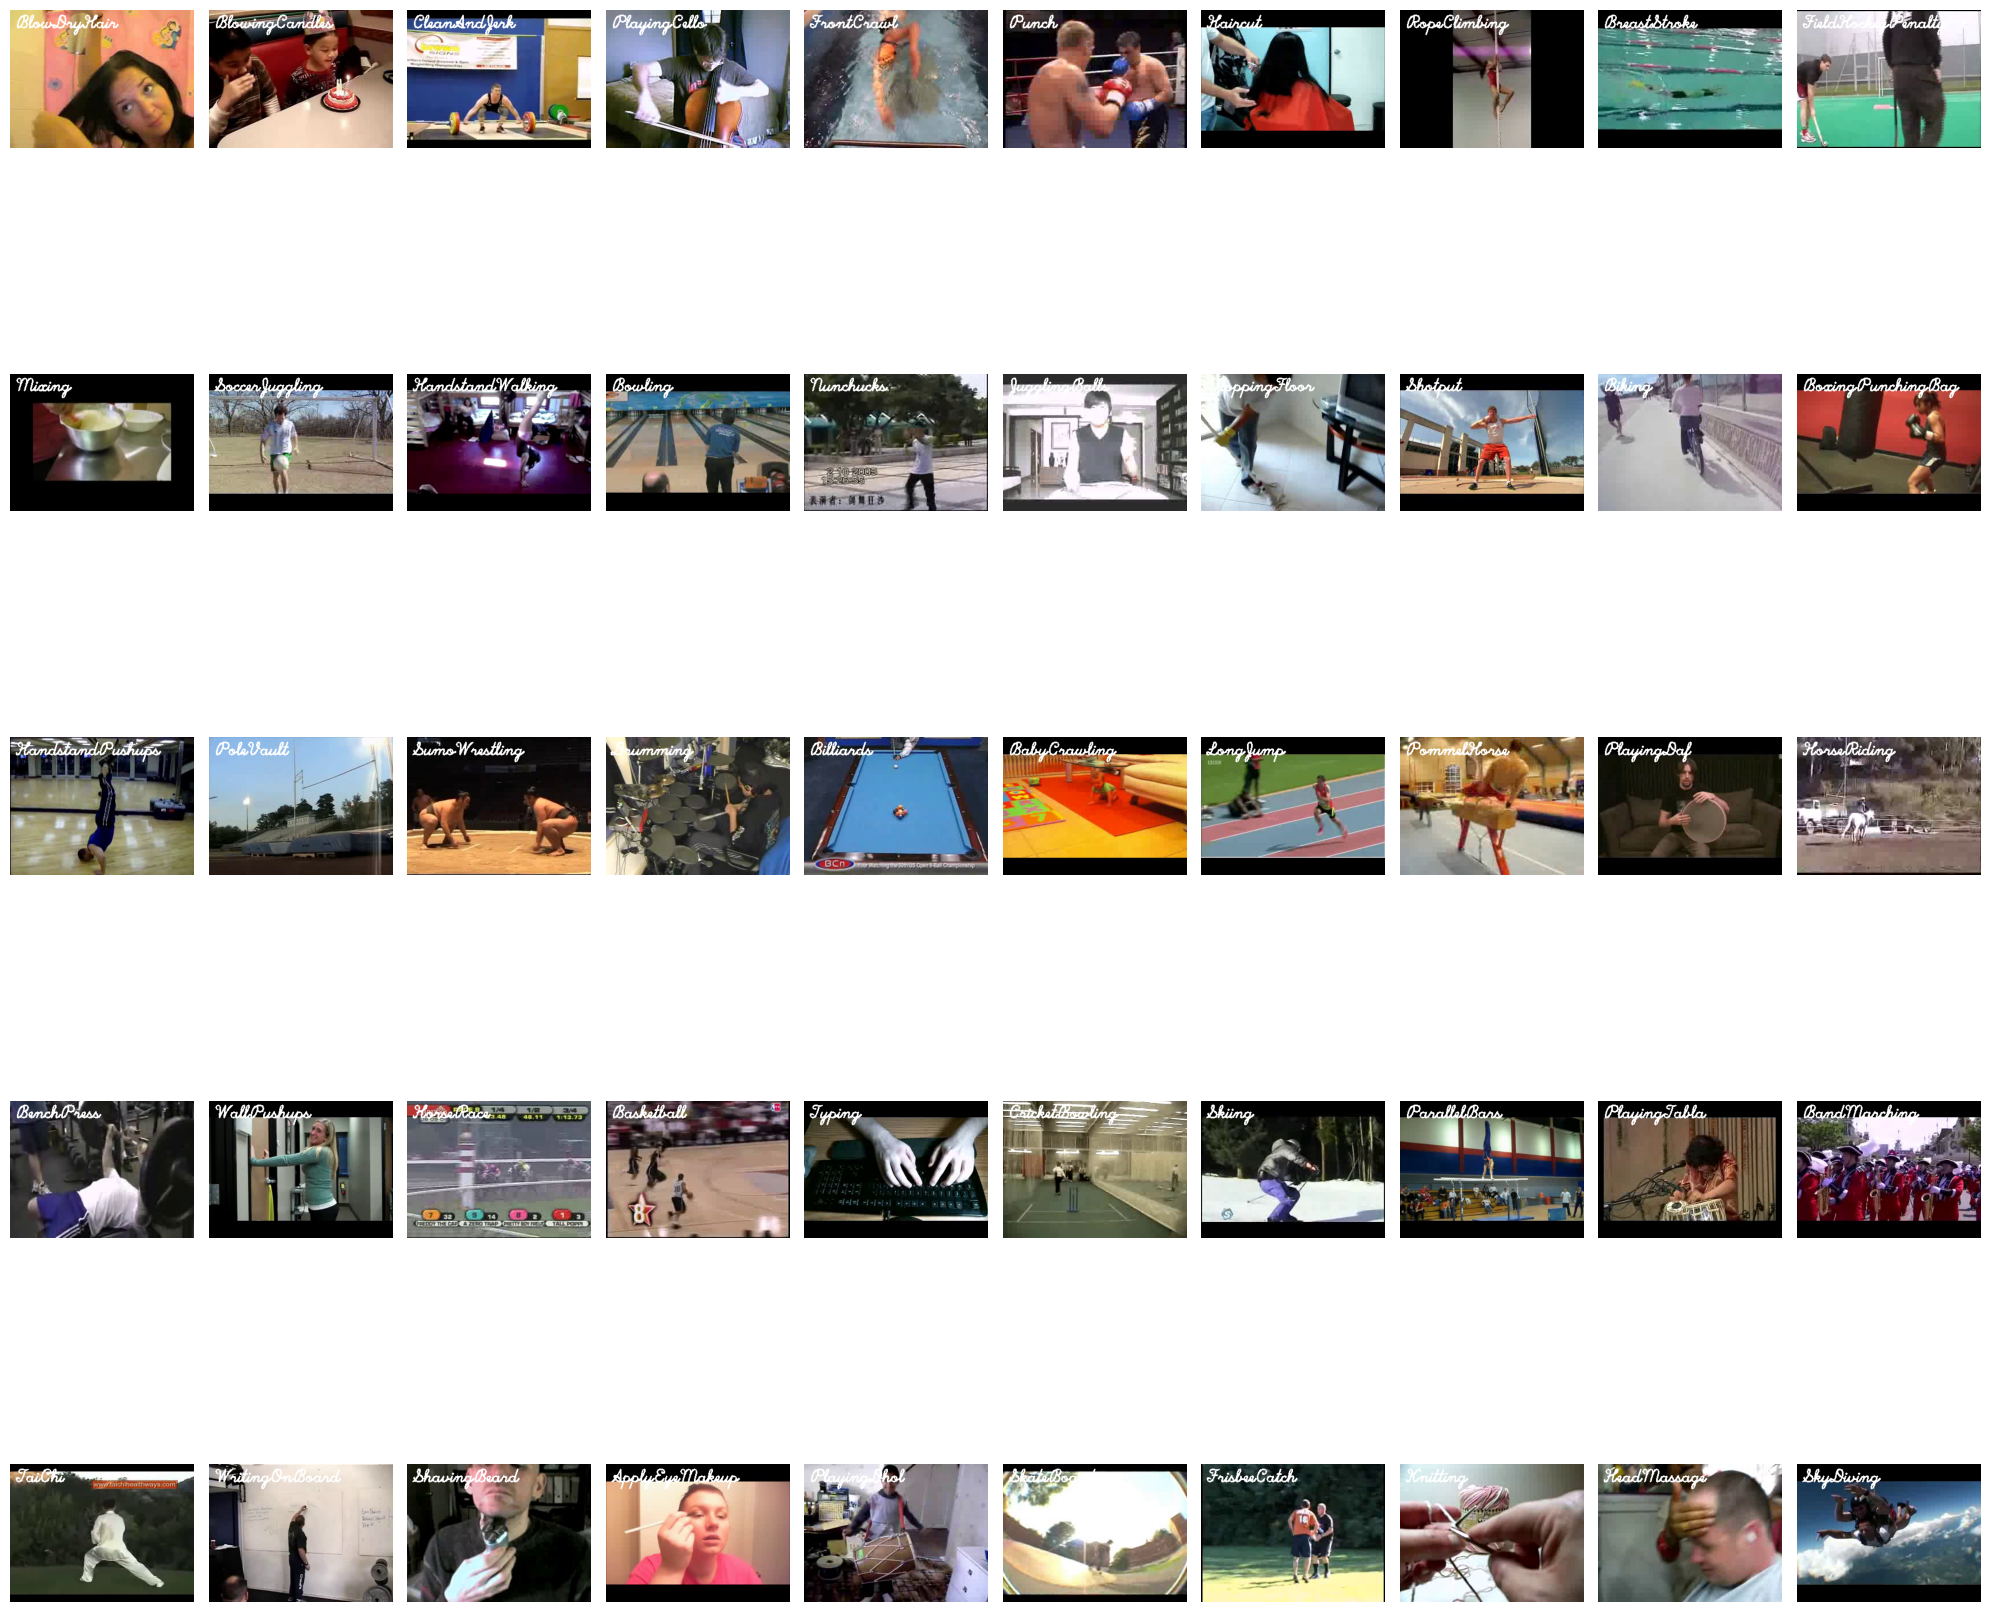

In [ ]:
import os        # Module for interacting with the operating system, like reading directories.
import random    # Module for generating random numbers and selections.
import cv2       # OpenCV library used for video processing and computer vision tasks.
import matplotlib.pyplot as plt  # Matplotlib library for plotting and displaying images.

plt.figure(figsize=(20,20))  # Creating a figure of size 20x20 inches to hold the image grid.

# Use the correct path to access the dataset
all_class_names = os.listdir('/kaggle/input/ucf101-action-recognition/train')
# Reads the list of class names (directories) from the dataset path.

# Determine the number of samples
num_samples = min(50, len(all_class_names))
# Sets the number of samples to 50 or the total number of classes, whichever is smaller.

# random.choices allows for repetitions, random.sample ensures unique random selections.
# If you want to allow repetitions to always get 50 samples, use this instead:
# random_range = random.choices(range(len(all_class_names)), k=50)

random_range = random.sample(range(len(all_class_names)), num_samples)
# Randomly select indices for the class names, without repetition.

for counter, random_index in enumerate(random_range, 1):
    # Loop through the randomly selected indices, starting with 1 for subplot indexing.
    selected_class_name = all_class_names[random_index]
    # Fetch the class name corresponding to the current random index.

    # Use the correct path to access the dataset
    video_files_names_list = os.listdir(f'/kaggle/input/ucf101-action-recognition/train/{selected_class_name}')
    # List all video files for the selected class.

    selected_video_file_name = random.choice(video_files_names_list)
    # Randomly select a video from the list of videos in the selected class.

    # Use the correct path to access the dataset
    video_reader = cv2.VideoCapture(f'/kaggle/input/ucf101-action-recognition/train/{selected_class_name}/{selected_video_file_name}')
    # Open the selected video file using OpenCV.

    ret, bgr_frame = video_reader.read()
    # Read the first frame of the video. The 'ret' variable indicates if the frame was read successfully,
    # and 'bgr_frame' holds the actual image data in BGR format.

    video_reader.release()
    # Release the video file after reading the first frame to free up resources.

    # Check if the frame was read correctly
    if not ret:
        # If 'ret' is False, meaning the frame could not be read, print an error message.
        print(f"Error reading frame from video: /kaggle/input/ucf101-action-recognition/train/{selected_class_name}/{selected_video_file_name}")
        continue  # Skip to the next iteration if reading failed.

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    # Convert the BGR frame to RGB format for correct color display in Matplotlib.

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (255,255,255), 2)
    # Add the class name as a text label on the image, using white color, at position (10, 30).

    plt.subplot(5, 10, counter)
    # Create a subplot in a 5x10 grid, indexed by the 'counter' value.
    plt.imshow(rgb_frame)  # Display the current frame (converted to RGB) in the subplot.
    plt.axis('off')  # Hide the axis for a cleaner display of the image.

plt.tight_layout()  # Adjust the layout to prevent overlapping of subplots.
plt.show()  # Display all the images in the grid.


In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT = 64, 64
# Define the dimensions for resizing each frame to 64x64 pixels.

SEQUENCE_LENGTH = 20
# Set the number of frames to be captured from each video. This will define how many frames make up one sequence.

DATASET_DIRECTORY = '/kaggle/input/ucf101-action-recognition/train/'
# Specify the directory path where the UCF101 training dataset is located.

CLASSES_LIST = ['PushUps', 'PlayingPiano', 'PizzaTossing', 'Lunges', 'HorseRiding']
# Define the list of specific action classes to be used from the dataset.


In [ ]:
def frames_extraction(video_path):
    # Define a function that takes the path to a video file and extracts frames.

    frames_list = []
    # Initialize an empty list to store the extracted frames.

    video_reader = cv2.VideoCapture(video_path)
    # Open the video file using OpenCV.

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Get the total number of frames in the video.

    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    # Calculate how many frames to skip between each extracted frame, ensuring at least one frame is skipped.
    # This ensures you capture `SEQUENCE_LENGTH` frames evenly distributed across the video.

    for frame_counter in range(SEQUENCE_LENGTH):
        # Loop through the sequence length to extract `SEQUENCE_LENGTH` frames.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        # Set the position of the video reader to the desired frame based on the skip window.

        success, frame = video_reader.read()
        # Read the frame at the current position. `success` will be False if there is an issue reading the frame.

        if not success:
            # If the frame cannot be read, break out of the loop.
            break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        # Resize the frame to the specified dimensions (IMAGE_WIDTH, IMAGE_HEIGHT).

        normalized_frame = resized_frame / 255
        # Normalize the pixel values of the frame by dividing by 255 to scale them between 0 and 1.

        frames_list.append(normalized_frame)
        # Append the normalized frame to the list of frames.

    video_reader.release()
    # Release the video file to free up resources after reading.

    return frames_list
    # Return the list of extracted frames.


In [ ]:
def create_dataset():
    # Define a function to create a dataset of features (video frames) and labels (class indices).

    features = []
    # Initialize an empty list to store the video frame sequences (features).

    labels = []
    # Initialize an empty list to store the labels corresponding to each video sequence (action class index).

    video_files_paths = []
    # Initialize an empty list to store the paths of the video files for reference or later use.

    for class_index, class_name in enumerate(CLASSES_LIST):
        # Loop over each class in the predefined `CLASSES_LIST`, where `class_index` is the numeric index of the class,
        # and `class_name` is the name of the action class (e.g., 'PushUps', 'PlayingPiano').

        print(f'Extracting Data of Class: {class_name}')
        # Print the current class name to monitor progress during dataset creation.

        files_list = os.listdir(os.path.join(DATASET_DIRECTORY, class_name))
        # List all the video files in the current class directory by joining the dataset path with the class name.

        for file_name in files_list:
            # Loop over each file (video) in the class directory.

            video_file_path = os.path.join(DATASET_DIRECTORY, class_name, file_name)
            # Create the full file path for the current video by joining the dataset directory, class name, and file name.

            frames = frames_extraction(video_file_path)
            # Extract frames from the video using the `frames_extraction()` function.

            if len(frames) == SEQUENCE_LENGTH:
                # Check if the extracted frames match the required `SEQUENCE_LENGTH`. Only include videos with the complete sequence length.

                features.append(frames)
                # Append the extracted frames (features) to the `features` list.

                labels.append(class_index)
                # Append the corresponding class index (label) to the `labels` list.

                video_files_paths.append(video_file_path)
                # Append the video file path to the `video_files_paths` list for tracking.

    features = np.asarray(features)
    # Convert the `features` list into a NumPy array for efficient numerical operations and storage.

    labels = np.array(labels)
    # Convert the `labels` list into a NumPy array for efficient processing.

    return features, labels, video_files_paths
    # Return the features (video frame sequences), labels (class indices), and video file paths.


In [ ]:
features, labels, video_files_path = create_dataset() #creates dataset with data from categories

Extracting Data of Class: PushUps
Extracting Data of Class: PlayingPiano
Extracting Data of Class: PizzaTossing
Extracting Data of Class: Lunges
Extracting Data of Class: HorseRiding


In [ ]:
one_hot_encoded_labels = to_categorical(labels) # encoding the labels using OHE

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
%%capture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense

def create_convlstm_model():
    model=Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.2, return_sequences = True, input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

    model.add(MaxPooling3D(pool_size = (1,2,2),padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3,3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3,3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.2, return_sequences = True))
    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()

    return model

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │          14,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,405 (185.18 KB)

 Trainable params: 47,405 (185.18 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


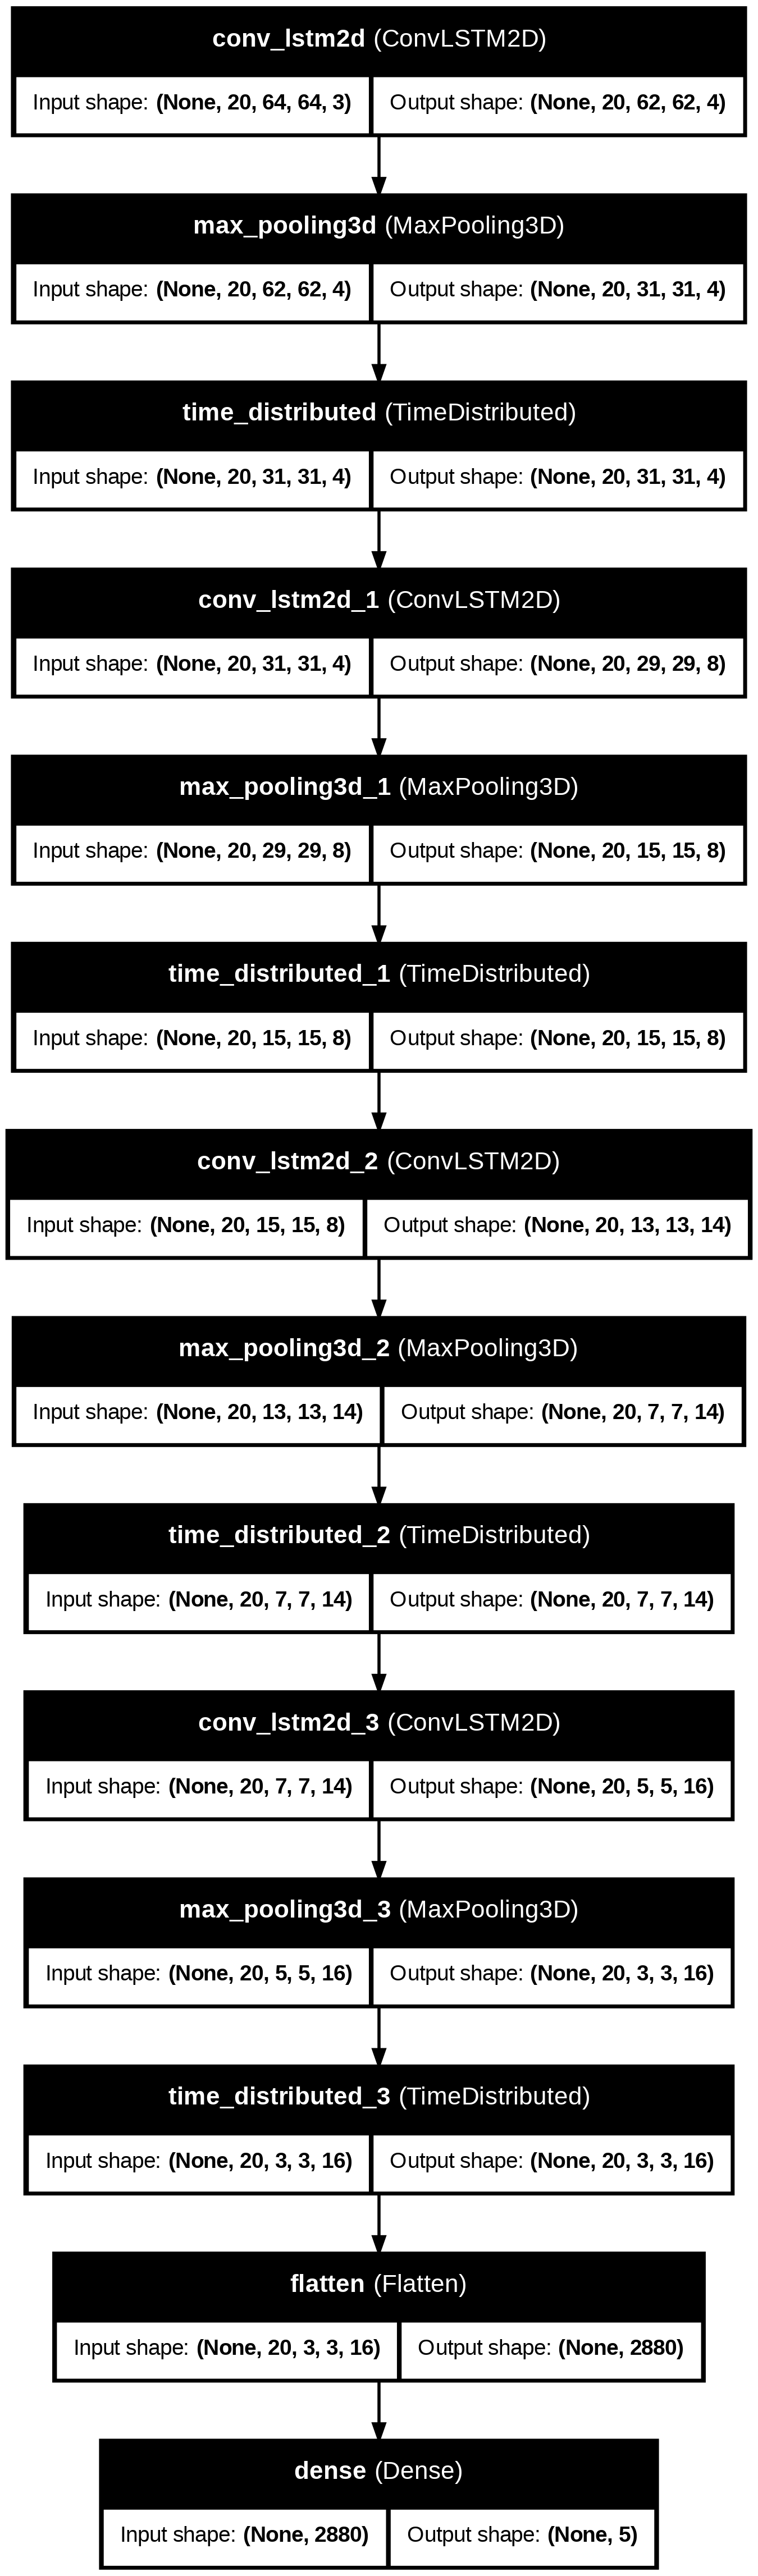

In [ ]:
plot_model(convlstm_model, to_file = "convlstm_model_structure_plot.png", show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.2181 - loss: 1.5760 - val_accuracy: 0.3768 - val_loss: 1.5272
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.4789 - loss: 1.3155 - val_accuracy: 0.4203 - val_loss: 1.3866
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5297 - loss: 1.1953 - val_accuracy: 0.4348 - val_loss: 1.2565
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5286 - loss: 1.0674 - val_accuracy: 0.4638 - val_loss: 1.2015
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.6187 - loss: 0.9872 - val_accuracy: 0.5362 - val_loss: 1.0866
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6587 - loss: 0.7984 - val_accuracy: 0.5362 - val_loss: 0.9459
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.7683 - loss: 0.5794 - val_accuracy: 0.6377 - val_loss: 0.8697
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.7978 - loss: 0.5094 - val_accuracy: 0.6667 - v

In [ ]:
# Evaluating the trained model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7731 - loss: 0.5811


In [ ]:
import datetime as dt # import the datetime module with the alias dt

# Evaluating the trained model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

# Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now() # use the alias dt to access the datetime module
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format) # use the alias dt to access the datetime module

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7731 - loss: 0.5811


In [ ]:
def plot_metric(model_training_history, metric_name1, metric_name2, plot_name):
    metric_value1 = model_training_history.history[metric_name1]
    metric_value2 = model_training_history.history[metric_name2]

    epochs = range(len(metric_value1))

    plt.plot(epochs, metric_value1, 'blue', label = metric_name1)
    plt.plot(epochs, metric_value2, 'red', label = metric_name2)

    plt.title(str(plot_name))

    plt.legend()

    plt.show()

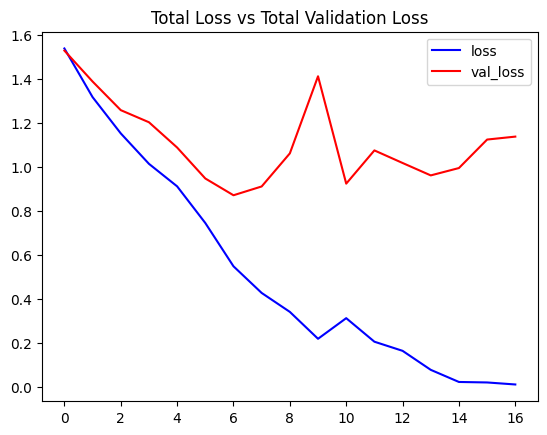

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

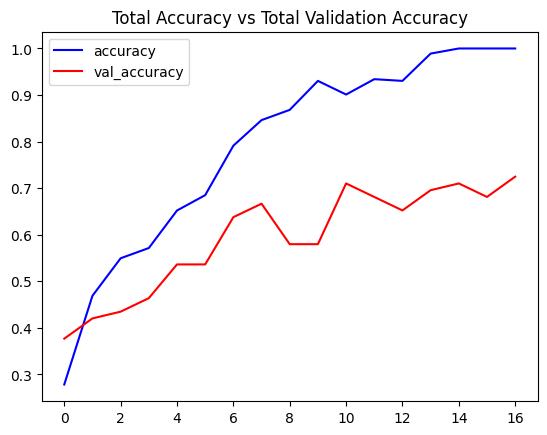

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
predictions = convlstm_model.predict(features_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.62      0.69        16
           1       0.90      1.00      0.95        19
           2       0.73      0.61      0.67        18
           3       0.61      0.74      0.67        23
           4       0.89      0.87      0.88        38

    accuracy                           0.79       114
   macro avg       0.78      0.77      0.77       114
weighted avg       0.79      0.79      0.79       114

